In [2]:
import sys
import math
import numpy as np
from scipy.special import digamma, gamma
from scipy.spatial.distance import mahalanobis as maha #cdist, pdist
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import cm as cm
%matplotlib inline
mpl.style.use('bmh')

def lDgamma(D, X):
    temp = np.array([math.lgamma(X-(i-1)/2) for i in range(1, D+1) ])
    return D*(D-1)/4*np.log(np.pi) + np.sum(temp)



def logsumexp(arr, axis=0):
    arr = np.rollaxis(arr, axis)
    # Use the max to normalize, as with the log this is what accumulates
    # the less errors
    vmax = arr.max(axis=0)
    out = np.log(np.sum(np.exp(arr - vmax), axis=0))
    out += vmax
    return out

In [3]:
data = np.genfromtxt('GaussianMixtureData20130501.txt')
data.shape, data

((1300, 2), array([[-15.58917842,  -7.63346546],
        [ 32.44378402,  20.34558427],
        [ 14.79851938,   8.05104279],
        ...,
        [-11.05030072,  -0.44787757],
        [ 38.7941563 , -16.22634439],
        [ 34.42639779, -23.64932431]]))

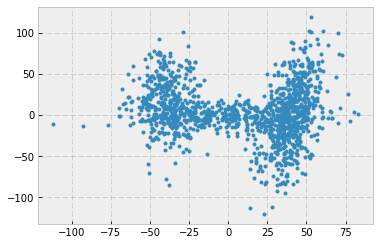

In [4]:
plt.plot(data.T[0], data.T[1], '.')

与えらえたデータはこんな感じ

# class 定義

In [5]:
class VariationalGaussianMixture():

    def __init__(self, n_component=10, alpha0=1.):

        # 混合ガウス分布の混合要素数
        self.n_component = n_component

        # 混合係数piの事前分布のパラメータ
        self.alpha0 = alpha0

    def init_params(self, X):
        self.sample_size, self.ndim = X.shape

        # 事前分布のパラメータを設定
        self.alpha0 = np.ones(self.n_component) *( self.ndim + 1)
        self.beta0 = np.ones(self.n_component)*( self.ndim + 1)
        self.m0 = np.array([np.mean(X[:,ii]) for ii in range(self.ndim)])
        self.nu0 = np.ones(self.n_component)*(self.ndim + 1) 
        self.W0 = np.linalg.inv( self.nu0[0]/self.sample_size*(X - self.m0*np.ones(X.shape)).T.dot( (X - self.m0*np.ones(X.shape) )) )

        self.component_size0 = self.sample_size / self.n_component + np.zeros(self.n_component)
        self.component_size = self.sample_size / self.n_component + np.zeros(self.n_component)

        # 確率分布のパラメータを初期化
        self.alpha = self.alpha0 + self.component_size
        self.beta = self.beta0 + self.component_size
        indices = np.random.choice(self.sample_size, self.n_component, replace=False)
        self.m = X[indices].T
        self.W = np.tile(self.W0, (self.n_component, 1, 1)).T
        self.nu = self.nu0 + self.component_size

    # 確率分布のパラメータを返す
    def get_params(self):
        return self.alpha, self.beta, self.m, self.W, self.nu

    # 変分ベイズ法
    def fit(self, X, iter_max=100):
        self.init_params(X)

        # 確率分布が収束するまで更新する
        for i in np.arange(0, iter_max):
            params = np.hstack([array.flatten() for array in self.get_params()])

            # 確率分布q(z)の更新
            r = self.e_like_step(X)

            # 確率分布q(pi, mu, Lambda)の更新
            self.m_like_step(X, r)
            # 収束していれば更新を止める。
            if np.allclose(params, np.hstack([array.ravel() for array in self.get_params()])):
                break
        else:
            print("parameters may not have converged")

    def e_like_step(self, X):#元のコード
        d = X[:, :, None] - self.m
        gauss = np.exp( -1/2 * self.ndim / self.beta - 1/2 * self.nu * np.sum( np.einsum('ijk,njk->nik', self.W, d) * d, axis=1) )
        pi = np.exp(digamma(self.alpha) - digamma(self.alpha.sum()))
        Lambda = np.exp(digamma(self.nu - np.arange(self.ndim)[:, None]).sum(axis=0) + self.ndim * np.log(2) + np.linalg.slogdet(self.W.T)[1])

        # PRML式(10.67) 負担率の計算
        r = pi * np.sqrt(Lambda) * gauss
        # PRML式(10.49) 負担率を正規化
        r /= np.sum(r, axis=-1, keepdims=True)
        # 0割が生じた場合
        r[np.isnan(r)] = 1. / self.n_component
        return r
    # 確率分布q(pi, mu, Lambda)の更新
    def m_like_step(self, X, r):
        # PRML式(10.51)
        self.component_size = r.sum(axis=0)
        # PRML式(10.52)
        Xm = X.T.dot(r) / self.component_size
        
        d = X[:, :, None] - Xm
        # PRML式(10.53)
        S = np.einsum('nik,njk->ijk', d, r[:, None, :] * d) / self.component_size

        # PRML式(10.58) q(pi)のパラメータを更新
        self.alpha = self.alpha0 + self.component_size

        # PRML式(10.60)
        self.beta = self.beta0 + self.component_size

        # PRML式(10.61)
        self.m = (self.beta0 * self.m0[:, None] + self.component_size * Xm) / self.beta

        d = Xm - self.m0[:, None]
        # PRML式(10.62)
        self.W = np.linalg.inv( np.linalg.inv(self.W0) + (self.component_size * S).T\
                               + (self.beta0 * self.component_size * np.einsum('ik,jk->ijk', d, d) / (self.beta0 + self.component_size)).T).T

        # PRML式(10.63)
        self.nu = self.nu0 + self.component_size

    # p(テストデータ|トレーニングデータ)をpi,mu,Lambdaの推定値で近似
    def predict_proba(self, X):

        # PRML式(B.80) 精度行列Lambdaの期待値
        covs = self.nu * self.W
        precisions = np.linalg.inv(covs.T).T

        d = X[:, :, None] - self.m
        exponents = np.sum(np.einsum('nik,ijk->njk', d, precisions) * d, axis=1)
        # PRML式(10.38)
        gausses = np.exp(-0.5 * exponents) / np.sqrt(np.linalg.det(covs.T).T * (2 * np.pi) ** self.ndim)

        # PRML式(10.69) 混合係数piの期待値
        gausses *= (self.alpha0 + self.component_size) / (self.n_component * self.alpha0 + self.sample_size)

        # 潜在変数zについて周辺化
        return np.sum(gausses, axis=-1)

    # クラスタリング
    def classify(self, X):
        # 確率分布q(Z)のargmax
        return np.argmax(self.e_like_step(X), 1)         
    
    def Selec_MN(self, X):
        temp1 = math.lgamma(self.n_component * self.alpha0[0] +  self.sample_size) - math.lgamma(self.n_component * self.alpha0[0])  
        temp2 = self.e_like_step(X)*np.log(self.e_like_step(X))
        temp2[np.isnan(temp2)] = 0
        temp3 = np.zeros(self.n_component)
        for k in range(self.n_component):#temp3[d]  =#
            temp3[k] = math.lgamma(self.alpha0[k]) - math.lgamma(self.alpha[k]) + lDgamma(self.ndim, self.nu0[k] /2) - lDgamma(self.ndim, self.nu[k]/2)
        temp4 = self.ndim*( np.log(self.beta) - np.log(self.beta0) ) \
        + self.nu0 * np.linalg.det(self.W0.T) - self.nu * np.linalg.det(self.W.T)  
        temp4[np.isnan(temp4)] = 0
        
        return temp1  + np.sum( np.sum( temp2,axis = 1 ) ) + np.sum( temp3 + 1/2*temp4 )  

# 計算実行＆図示

混合数選択基準、KL距離の内混合数に依存する項が最小になるようにする。混合数は3になるはずなんだけど、計算が合っていなそう。

In [6]:
X = data
model = {}
labels= {}
selection = {}
for i in range(1,11):
    model[i] = VariationalGaussianMixture(n_component=i)
    model[i].fit(X, iter_max=500)
    labels[i] = model[i].classify(X)
    selection[i] = model[i].Selec_MN(X)
selection

C:\Users\Shinji Nakagami\Anaconda3\lib\site-packages\ipykernel\__main__.py:64: RuntimeWarning: invalid value encountered in true_divide


{1: -7125.665210242097,
 2: -5409.32765683415,
 3: -4738.054599659248,
 4: -4707.483746691671,
 5: -4678.438955644993,
 6: -4650.629760719293,
 7: -4623.85821377174,
 8: -4597.981599331475,
 9: -4572.889539835713,
 10: -4548.4960392086805}

C:\Users\Shinji Nakagami\Anaconda3\lib\site-packages\ipykernel\__main__.py:64: RuntimeWarning: invalid value encountered in true_divide


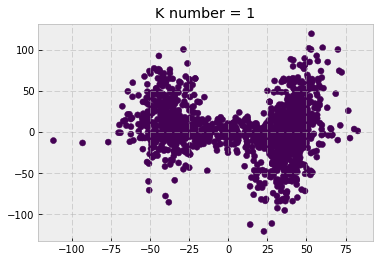

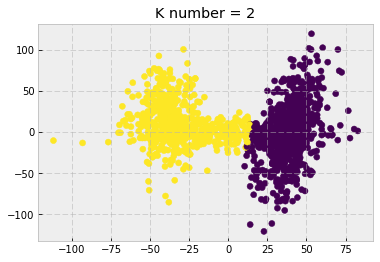

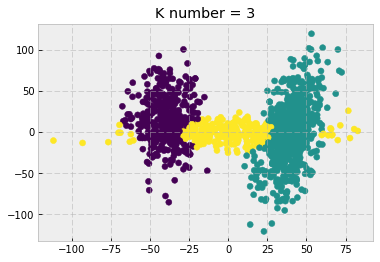

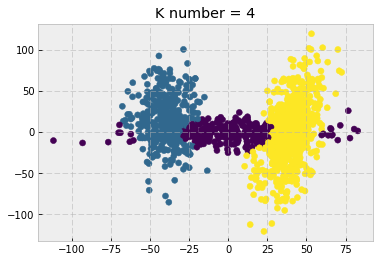

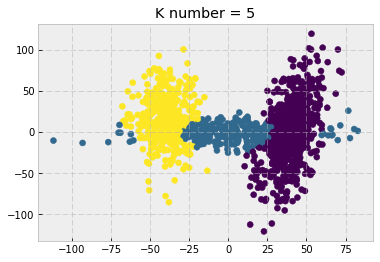

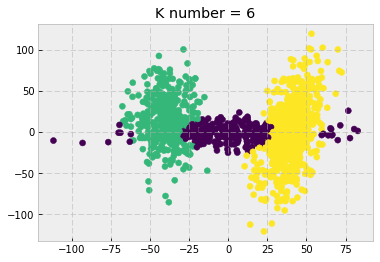

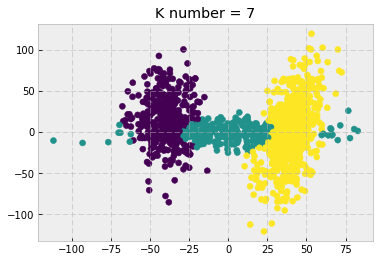

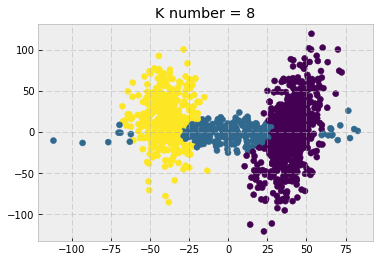

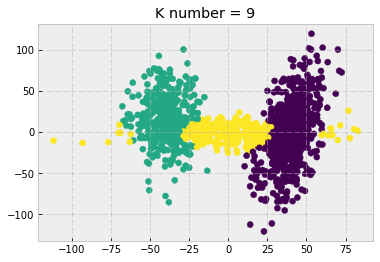

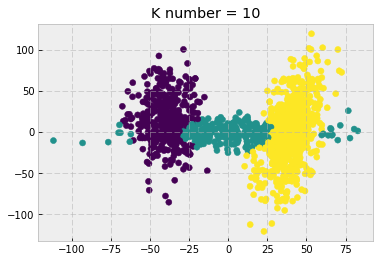

In [7]:
for i in range(1,11):
    model[i] = VariationalGaussianMixture(n_component=i)
    model[i].fit(X, iter_max=500)
    x_test, y_test = np.meshgrid(np.linspace(-10, 10, 100), np.linspace(-10, 10, 100))
    X_test = np.array([x_test, y_test]).reshape(2, -1).transpose()
    plt.scatter(X[:, 0], X[:, 1], c=labels[i], cmap=cm.get_cmap())
    plt.title("K number = %d" %i)
    plt.show()

# 解

In [8]:
#混合、平均m、共分散W
covariance  = model[3].get_params()[-2].T
mixstuer = model[3].get_params()[0]/np.sum(model[3].get_params()[0])
avg = model[3].get_params()[-3].T
avg, mixstuer, covariance

(array([[ 39.7970777 ,  -0.13772325],
        [  1.11238104,  -0.65574138],
        [-38.39206185,  17.12610041]]),
 array([0.4642482 , 0.26849444, 0.26725736]),
 array([[[ 1.82637873e-05, -2.24474975e-06],
         [-2.24474975e-06,  1.32868792e-06]],
 
        [[ 2.94173664e-06, -3.92602997e-07],
         [-3.92602997e-07,  2.65010262e-05]],
 
        [[ 1.91824755e-05,  5.39708531e-07],
         [ 5.39708531e-07,  3.06875197e-06]]]))

In [9]:
labels

{1: array([0, 0, 0, ..., 0, 0, 0], dtype=int64),
 2: array([1, 0, 0, ..., 1, 0, 0], dtype=int64),
 3: array([2, 1, 2, ..., 2, 1, 1], dtype=int64),
 4: array([0, 3, 0, ..., 0, 3, 3], dtype=int64),
 5: array([1, 0, 1, ..., 1, 0, 0], dtype=int64),
 6: array([2, 5, 2, ..., 2, 5, 5], dtype=int64),
 7: array([4, 6, 4, ..., 4, 6, 6], dtype=int64),
 8: array([3, 1, 3, ..., 3, 1, 1], dtype=int64),
 9: array([6, 1, 6, ..., 6, 1, 1], dtype=int64),
 10: array([4, 7, 4, ..., 4, 7, 7], dtype=int64)}

# mahalanobis距離

In [10]:
dataK = {}
dataK[0] = X[np.where(labels[3] == 0)]
dataK[1] = X[np.where(labels[3] == 1)]
dataK[2] = X[np.where(labels[3] == 2)]

def mahalano(X, Y, j):
    Xin = np.array([X, Y]).T
    Avg = np.mean(dataK[j], axis = 0)
    COV = np.linalg.inv(np.cov(dataK[j].T))
    temp = np.array([ maha(Xin[i][j], Avg, COV) for i in np.arange(len(X)) for j in np.arange(len(Y))])
    return temp.reshape(len(X), len(Y))

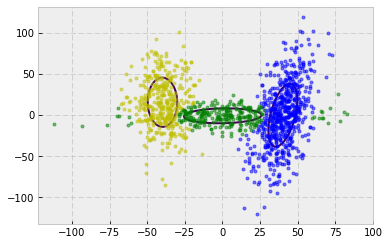

In [11]:
xrange =np.linspace(-100, 100, 1000)
yrange =np.linspace(-100, 100, 1000)

Xrange, Yrange = np.meshgrid(xrange, yrange)
Z = {}
for j in np.arange(3):
    Z[j] = mahalano(Xrange,Yrange, j) -1
plt.contour(Yrange, Xrange, Z[0], [0])
plt.contour(Yrange, Xrange, Z[1], [0])
plt.contour(Yrange, Xrange, Z[2], [0])
plt.plot(dataK[0][:,0], dataK[0][:,1], '.', color = 'y', alpha = 0.5 )
plt.plot(dataK[1][:,0], dataK[1][:,1], '.', color = 'b', alpha = 0.5 )
plt.plot(dataK[2][:,0], dataK[2][:,1], '.', color = 'g', alpha = 0.5 )
plt.show()